### External Validation Test for MHC Class II Prediction

This notebook performs external validation testing based on five pre-trained models for MHC Class II prediction. The goal is to evaluate the performance of the trained models on external data.

#### Requirements
1. **Amino acid interaction preference matrix between HLA allele and immunogenic peptide** : Should be used generated feature matrix file
2. **Pre-trained Model Weights**: Weights from five fold based trained models.
3. **Feature Indices**: Selected feature indices obtained using RFECV.
4. **External Dataset**: Contains 200 samples also known as independent  or unseen data.
5. **Keras Functional API Models**:  Model  built using Keras Functional API.

### Purpose
To validate the robustness and accuracy of the trained models on unseen external data and analyze their predictive performance.


In [1]:
import os
import sys
os.environ["CUDa_VISIBLE-DEVICES"] = "0" ## GPU Selection

In [3]:
import pickle
import numpy as np
import gzip
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score, 
    confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, 
    Add, Bidirectional, LSTM
)
from tensorflow.keras.models import Model
from keras_self_attention import SeqSelfAttention
from keras.losses import binary_crossentropy, binary_focal_crossentropy
from keras.utils import plot_model
from matplotlib import pyplot as plt

In [7]:
print(f' keras version {keras.__version__}'), 
print(f' tensorflow version {tf.__version__}'),
print(f' python version {sys.version.split()[0]}')

 keras version 3.4.1
 tensorflow version 2.16.2
 python version 3.11.9


In [13]:
## Keras functional API model for MHC Class II
def model_with_attention2():
    input_shape = (807, 1)  # one-dimensional
    input_layer = Input(shape=input_shape, name='input_layer')
    # Convolutional blocks with residual connections
    x = Conv1D(32, kernel_size=5, activation='relu', padding='same', name = "Convolutional_first_layer")(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling1D()(x)
    x = Dropout(0.5)(x)
    shortcut = x
    x = Conv1D(32, kernel_size=5, activation='relu', padding='same',)(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = Conv1D(64, kernel_size=5, activation='relu', padding='same', name =  "Convolutional_Second_layer")(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D()(x)
    x = Dropout(0.5)(x)
    # Attention layer
    att = SeqSelfAttention(attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                attention_activation='sigmoid', name = "Attentinon_layer")(x)
    flatten = Flatten()(att)
    output_layer = Dense(1, activation='sigmoid', name='output_layer')(flatten)
    model = Model(inputs=input_layer, outputs=output_layer)
    learning_rate = 0.00191512  
    optimizer = RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=binary_crossentropy, metrics=['accuracy'])
    model.summary()
    return model

In [14]:
model = model_with_attention2()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 807, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Convolutional_firs… │ (None, 807, 32)   │        192 │ input_layer[0][0] │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 807, 32)   │        128 │ Convolutional_fi… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 403, 32)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 403, 32)   │          0 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 403, 32)   │      5,152 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 403, 32)   │        128 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 403, 32)   │          0 │ batch_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Convolutional_Seco… │ (None, 403, 64)   │     10,304 │ add_1[0][0]       │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 403, 64)   │        256 │ Convolutional_Se… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 201, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 201, 64)   │          0 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Attentinon_layer    │ (None, 201, 64)   │      4,097 │ dropout_3[0][0]   │
│ (SeqSelfAttention)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 12864)     │          0 │ Attentinon_layer… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 1)         │     12,865 │ flatten_1[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,122 (129.38 KB)

 Trainable params: 32,866 (128.38 KB)

 Non-trainable params: 256 (1.00 KB)

In [12]:
## load the feature matrix file generated based on aminoacid interactin matrix between peptide and HLA allele
with gzip.open("/BiO/home/jk/Research_MHC/Feature_generation/Feature_MHC_ii_our_independent_200_double_allele_included") as f:
    ind = pickle.load(f)
print(f"Type of first element: {type(ind[0])}")
print(f"Shape of feature data: {ind[0].shape}")
print(f"Shape of labels: {ind[1].shape}")

positive = np.sum(ind[1] == 1) # positive class
negative = np.sum(ind[1] == 0) # negative
print(f"Number of positive samples: {positive}")
print(f"Number of negative samples: {negative}")

data_ind = ind[0]  # Feature data
label_ind = ind[1]  # Labels


Type of first element: <class 'numpy.ndarray'>
Shape of feature data: (200, 4035)
Shape of labels: (200,)
Number of positive samples: 114
Number of negative samples: 86


In [15]:
data_ind

array([[-0.188 , -0.292 , -0.266 , ...,  0.    ,  0.    ,  0.    ],
       [-0.116 , -0.214 , -0.164 , ...,  0.    ,  0.    ,  0.    ],
       [-0.116 , -0.214 , -0.164 , ...,  0.    ,  0.    ,  0.    ],
       ...,
       [-0.116 , -0.0805, -0.1625, ..., -0.046 , -0.046 ,  0.019 ],
       [-0.116 , -0.116 , -0.214 , ...,  0.    ,  0.    ,  0.    ],
       [-0.153 , -0.149 , -0.272 , ...,  0.    ,  0.    ,  0.    ]],
      dtype=float32)

### The selected feature indices file from the trained RFECV must be loaded and then use to encode the external validation data set

In [53]:
load_features = np.load("selected_feature_mhc_ii_duplicate_checked.npy") # feature index from RFECV

In [54]:
selected_feature_indices = np.where(load_features)[0]

In [55]:
data_selected = data_ind[:, selected_feature_indices] # encoding

In [31]:
data_selected = data_selected.reshape(200, 807,1) # 200 sample with 807 optimal number of features (ONF)

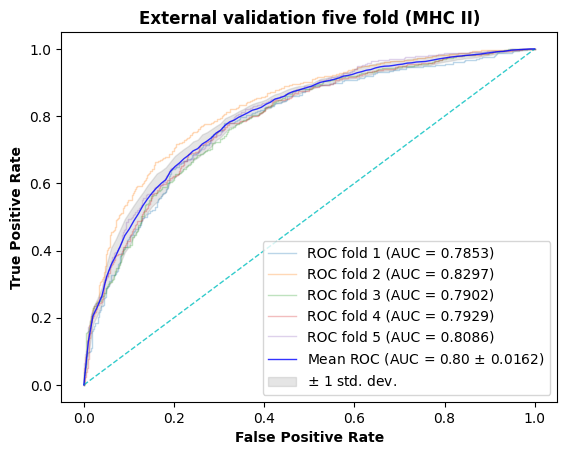

In [26]:
def ROC(temp, OutputDir):  ### Roc curve
    validation_result = temp;
    for x in [validation_result]:

        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        i = 0
        for val in x:
            tpr = val['tpr']
            fpr = val['fpr']
            tprs.append(np.interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.4f)' % (i+1, roc_auc))

            i += 1

        print;

        plt.plot([0, 1], [0, 1], linestyle='--', lw=1,color='c' , alpha=.8)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr, color='b',
                 label=r'Mean ROC (AUC = %0.2f $\pm$ %0.4f)' % (mean_auc, std_auc),
                 lw=1, alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                         label=r'$\pm$ 1 std. dev.')

        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate',fontweight='bold')
        plt.ylabel('True Positive Rate',fontweight='bold')
        plt.legend(loc="lower right")
        plt.title(" External validation five fold (MHC II)", fontweight='bold')
        plt.savefig('roc_External validation_independet MHC II.pdf') #save the figure in your file path
        plt.show()
        plt.close('all')
        
def cal(X,y, model):
    pred_y =  model.predict(X)
    ROCArea = roc_auc_score(y, pred_y)
    print(ROCArea)
    fpr, tpr, thresholds = roc_curve(y, pred_y)
    lossValue = None
    
    pre, rec, threshlds = precision_recall_curve(y, pred_y)
    pre = np.fliplr([pre])[0]  
    rec = np.fliplr([rec])[0]  
    AUC_prec_rec = np.trapz(rec,pre)
    AUC_prec_rec = abs(AUC_prec_rec)
    
    
    return { 'fpr' : fpr, 'tpr' : tpr, 'thresholds' : thresholds,'pre_recall_curve':AUC_prec_rec,'prec':pre,'reca':rec}      

        
import warnings
warnings.filterwarnings("ignore")
OutputDir=" " # give your own path 
validation_result=[]
for i in range(5):
        model.load_weights(str(i+0)+'MHCiiLastepoch_new'+'.h5') # load model weights for five folds
        validation_result.append(cal(data_selected,label_ind, model))
temp_dict = (validation_result)
ROC(temp_dict, OutputDir)
